# Gross Margin vs Volatility (2nd Question Analysis) - A. Sachit

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tqdm import tqdm
import os

sns.set_style("darkgrid")


### File Paths Setup

In [31]:
gross_margin_cache_path = "data/gross_margins_cache.csv"
price_data_path = "data/final_updated_historical_stock_prices.csv"
ticker_data_path = "data/all-defense-stocks.csv"


### Load Defense Stock Tickers

In [32]:
gross_df = pd.read_csv(ticker_data_path)
tickers = gross_df['Symbol'].dropna().unique().tolist()


### Step 1: Get Gross Margin Data

In [33]:
if os.path.exists(gross_margin_cache_path):
    gross_margin_df = pd.read_csv(gross_margin_cache_path)
    print("Loaded Gross Margin data from cache.")
else:
    print("Fetching Gross Margin data from Yahoo Finance...")
    gross_margin_data = {'Ticker': [], 'Gross Margin': []}

    for ticker in tqdm(tickers):
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            gm = info.get('grossMargins', None)
            gross_margin_data['Ticker'].append(ticker)
            gross_margin_data['Gross Margin'].append(gm)
        except Exception as e:
            print(f"Error for {ticker}: {e}")
            gross_margin_data['Ticker'].append(ticker)
            gross_margin_data['Gross Margin'].append(None)

    gross_margin_df = pd.DataFrame(gross_margin_data).dropna()
    gross_margin_df.to_csv(gross_margin_cache_path, index=False)
    print(f"Saved Gross Margin data to {gross_margin_cache_path}")


Loaded Gross Margin data from cache.


### Step 2: Load Historical Stock Prices & Compute Volatility

In [34]:
price_df = pd.read_csv(price_data_path, index_col=0, parse_dates=True)
returns = price_df.pct_change()
volatility = returns.std()

vol_df = pd.DataFrame({'Ticker': volatility.index, 'Volatility': volatility.values})


C:\Users\Ahmed's PC\AppData\Local\Temp\ipykernel_10904\4251584049.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_df = pd.read_csv(price_data_path, index_col=0, parse_dates=True)


### Step 3 (Updated): Clean Data

In [35]:
# Filter out extreme gross margin values
analysis_df = pd.merge(gross_margin_df, vol_df, on='Ticker')
analysis_df = analysis_df.dropna()
analysis_df = analysis_df[analysis_df['Gross Margin'].between(0, 1.0)]


### Optional: Add Sector Information (if available)

In [36]:
if 'Sector' in gross_df.columns:
    sector_map = gross_df.set_index('Symbol')['Sector'].to_dict()
    analysis_df['Sector'] = analysis_df['Ticker'].map(sector_map)
else:
    analysis_df['Sector'] = 'Unknown'


### Step 4 (Updated): Scatter Plot with Regression Line

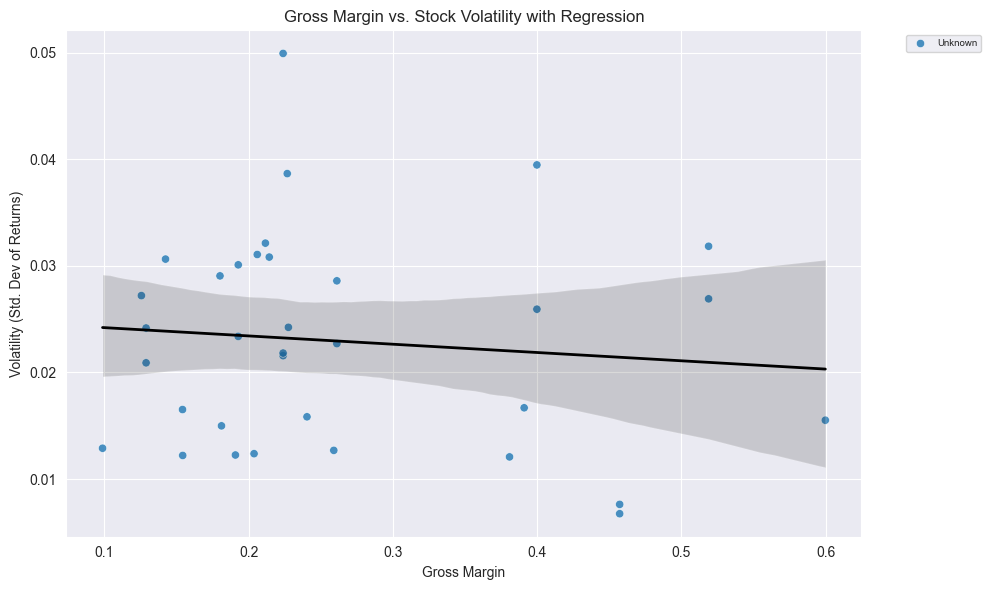

In [37]:
plt.figure(figsize=(10, 6))
if 'Sector' in analysis_df.columns:
    sns.scatterplot(data=analysis_df, x='Gross Margin', y='Volatility', hue='Sector', palette='tab10', alpha=0.8)
else:
    sns.scatterplot(data=analysis_df, x='Gross Margin', y='Volatility', hue='Ticker', palette='tab10', alpha=0.8)

sns.regplot(data=analysis_df, x='Gross Margin', y='Volatility', scatter=False, color='black', line_kws={'linewidth': 2})

plt.title("Gross Margin vs. Stock Volatility with Regression")
plt.xlabel("Gross Margin")
plt.ylabel("Volatility (Std. Dev of Returns)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.tight_layout()
plt.savefig("plots/gross_margin_vs_volatility_with_regression.png", dpi=300)
plt.show()


### Step 5 (Updated): Volatility by Gross Margin Tier

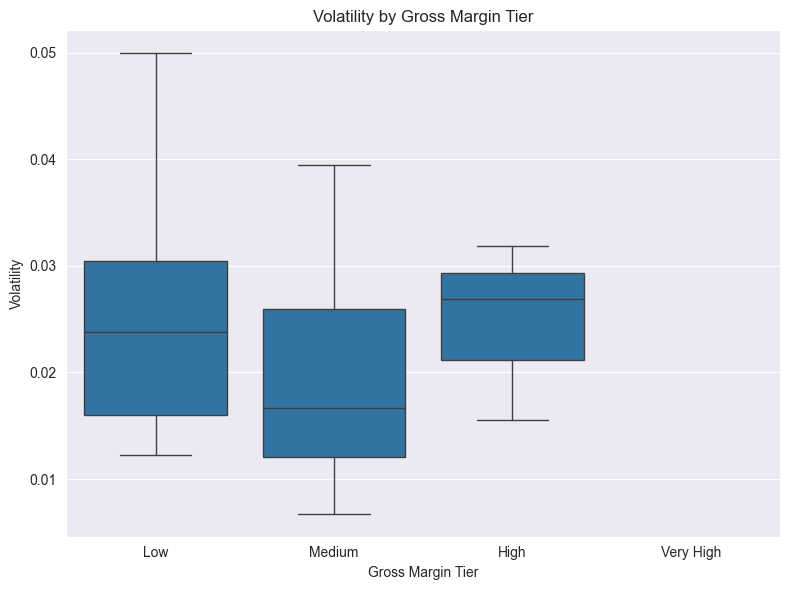

In [38]:
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['Low', 'Medium', 'High', 'Very High']
analysis_df['Margin Tier'] = pd.cut(analysis_df['Gross Margin'], bins=bins, labels=labels)

plt.figure(figsize=(8, 6))
sns.boxplot(data=analysis_df, x='Margin Tier', y='Volatility')
plt.title("Volatility by Gross Margin Tier")
plt.xlabel("Gross Margin Tier")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig("plots/volatility_by_margin_tier_updated.png", dpi=300)
plt.show()
